\begin{equation}
\begin{aligned}
& \frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x}+v \frac{\partial u}{\partial y}=-\frac{1}{\rho} \frac{\partial p}{\partial x}+\nu\left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right) \\
& \frac{\partial v}{\partial t}+u \frac{\partial v}{\partial x}+v \frac{\partial v}{\partial y}=-\frac{1}{\rho} \frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right) \\
& \frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2}=-\rho\left(\frac{\partial u}{\partial x} \frac{\partial u}{\partial x}+2 \frac{\partial u}{\partial y} \frac{\partial v}{\partial x}+\frac{\partial v}{\partial y} \frac{\partial v}{\partial y}\right)
\end{aligned}
\end{equation}

In [4]:
#Librería para plotear en 3D
from mpl_toolkits.mplot3d import Axes3D

#Incluímos las librerías que vamos a usar
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time, sys

In [38]:
class domain:    
    #El constructor se encarga de hacer el preprocesamiento
    def __init__(self, Lx, Ly, dx, dy):       
        self.Nx = int(Lx/dx)                     #Número de puntos desde 0 hasta Nx
        self.x = np.linspace(0, Lx, self.Nx+1)   #Creo un vector que va desde el 0 hasta Lx con Nx+1 divisiones
        self.dx = self.x[1]-self.x[0]            #Chequeo del dx, para que coincida
        
        self.Ny = int(Ly/dy)                     #Número de puntos desde 0 hasta Ny
        self.y = np.linspace(0, Ly, self.Ny+1)   #Creo un vector que va desde el 0 hasta Ly con Ny+1 divisiones
        self.dy = self.y[1]-self.y[0]            #Chequeo del dy, para que coincida

        self.X, self.Y = np.meshgrid(self.x, self.y)

        fig = plt.figure()                                           #Creo una ventana
        ax = fig.add_subplot(111)                                    #A la ventana le añado un plano en 2d

        for i in range(0,self.Nx+1):
            ax.plot(self.X[:,i], self.Y[:,0], color='k')

        for i in range(0,self.Nx+1):
            ax.plot(self.X[0,:], self.Y[i,:], color='k')

        ax.plot(self.X, self.Y, color = 'k', ls='None', marker='.')  #Dentro del plano creado grafico 
        plt.xlim([0, Lx])
        plt.ylim([0, Ly])
        plt.title('Grid of the domain')
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.show

    def constantes(self, eta, rho):

        #Definición de todas las constantes
        alfa = float(eta*self.dt/(self.dx)**2) 
        beta = float(eta*self.dt/(self.dy)**2)
        C = float(self.dt/(2*self.dx*rho))
        D = float(self.dt/(2*self.dy*rho))
        E = float(self.dt/self.dx)
        F = float(self.dt/self.dy)
        R = float((-rho*self.dx**2*self.dy**2)/(2*(self.dx**2+self.dy**2)))

        return alfa, beta, C, D, E, F, R 
    
    def pressure(self, R, u2, v2, P2):
        for n in range(50):
            P1 = P2.copy()
            P2 [1:-1,1:-1] = (self.dy**2*(P1[1:-1, 2:]+P1[1:-1,:-2]) + 
                            self.dx**2*(P1[2:,1:-1]+P1[:-2,1:-1]))/(2*(self.dx**2+self.dy**2)) - \
                            R*(1/self.dt*((u2[1:-1,2:]-u2[1:-1,:-2])/(2*self.dx) + (v2[2:, 1:-1]-v2[:-2,1:-1])/(2*self.dy)) -
                                ((u2[1:-1,2:]-u2[1:-1,:-2])/(2*self.dx))**2 - 
                                2*(u2[2:,1:-1]-u2[:-2,1:-1])/(2*self.dy)*(v2[1:-1,2:]-v2[1:-1,:-2])/(2*self.dx) +
                                ((v2[2:, 1:-1]-v2[:-2,1:-1])/(2*self.dy))**2)
            
            #Condiciones de frontera
            P2[:,0] = P2[:,1]   #dp/dx=0 en x=0
            P2[:,-1] = P2[:,-2] #dp/dx=0 en x=Lx
            P2[-1,:] = P2[-2,:] #dp/dy=0 en y=0
            P2[0,:] = 0          #p=0 y=Ly - Presión atmosférica en la superficie

        return P2

    def velocity(self, T, dt, eta, rho):
        self.Nt = int(T/dt)                       #Número de puntos desde 0 hasta Nt
        self.t = np.linspace(0, T, self.Nt+1)     #Creo un vector que va desde el 0 hasta T con Nt+1 divisiones
        self.dt = self.t[1]-self.t[0]             #Chequeo del dt, para que coincida

        #Constante para definir todas las variables
        alfa, beta, C, D, E, F, R = self.constantes(eta, rho)

        #Initial conditions: U, V, P = 0 at time t=0
        u2 = np.zeros((self.Nx+1, self.Ny+1))
        v2 = np.zeros((self.Nx+1, self.Ny+1))
        P2  = np.zeros((self.Nx+1, self.Ny+1))

        for n in range(1, self.Nt):
            u1 = u2.copy()
            v1 = v2.copy()
            #Uso el corrector de la ecuación de continuidad
            P2 = self.pressure(R, u2, v2, P2)

            u2[1:-1,1:-1] = u1[1:-1,1:-1] -\
                            E*u1[1:-1,1:-1]*(u1[1:-1,1:-1] - u1[1:-1,:-2]) - \
                            F*v1[1:-1,1:-1]*(u1[1:-1,1:-1]-u1[:-2,1:-1]) - \
                            C*(P2[1:-1, 2:]-P2[1:-1,:-2]) +\
                            alfa*(u1[1:-1,2:] - 2*u1[1:-1,1:-1] + u1[1:-1,:-2]) +\
                            beta*(u1[2:,1:-1] - 2*u1[1:-1,1:-1] + u1[:-2,1:-1])
            
            v2[1:-1,1:-1] = v1[1:-1,1:-1] -\
                            E*u1[1:-1,1:-1]*(v1[1:-1,1:-1] - v1[1:-1,:-2]) - \
                            F*v1[1:-1,1:-1]*(v1[1:-1,1:-1]-v1[:-2,1:-1]) - \
                            D*(P2[2:,1:-1]-P2[:-2,1:-1]) +\
                            alfa*(v1[1:-1,2:] - 2*u1[1:-1,1:-1] + v1[1:-1,:-2]) +\
                            beta*(v1[2:,1:-1] - 2*v1[1:-1,1:-1] + v1[:-2,1:-1])
            
            #Después del primer paso temporal entran en vigencia las condiciones de frontera para la velocidad
            u2[:,0] = 0 #Condición de no deslizamientos
            v2[:,0] = 0
            u2[:,-1] = 0
            v2[:,-1] = 0
            u2[-1,:] = 0
            v2[-1,:] = 0
            u2[0,:] = 1   #La tapa que se mueve
            v2[0,:] = 0

        #Luego de solucionar el caso, hago que las matrices sean atributos de la clase 
        self.u2 = u2
        self.v2 = v2
        self.P2 = P2

    def plotter(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        pressure = ax.contourf(self.X, self.Y, self.P2, cmap = 'coolwarm')
        fig.colorbar(pressure)
        ax.set_title('Simulation at t={:.2f}'.format(self.t[-1]))
        ax.set_xlabel('$x[m]$')
        ax.set_ylabel('$y[m]$')





C:\Users\juanse\AppData\Local\Temp\ipykernel_7288\779861362.py:50: RuntimeWarning: overflow encountered in square
  ((u2[1:-1,2:]-u2[1:-1,:-2])/(2*self.dx))**2 -
C:\Users\juanse\AppData\Local\Temp\ipykernel_7288\779861362.py:51: RuntimeWarning: overflow encountered in multiply
  2*(u2[2:,1:-1]-u2[:-2,1:-1])/(2*self.dy)*(v2[1:-1,2:]-v2[1:-1,:-2])/(2*self.dx) +
C:\Users\juanse\AppData\Local\Temp\ipykernel_7288\779861362.py:52: RuntimeWarning: overflow encountered in square
  ((v2[2:, 1:-1]-v2[:-2,1:-1])/(2*self.dy))**2)
C:\Users\juanse\AppData\Local\Temp\ipykernel_7288\779861362.py:49: RuntimeWarning: invalid value encountered in add
  R*(1/self.dt*((u2[1:-1,2:]-u2[1:-1,:-2])/(2*self.dx) + (v2[2:, 1:-1]-v2[:-2,1:-1])/(2*self.dy)) -


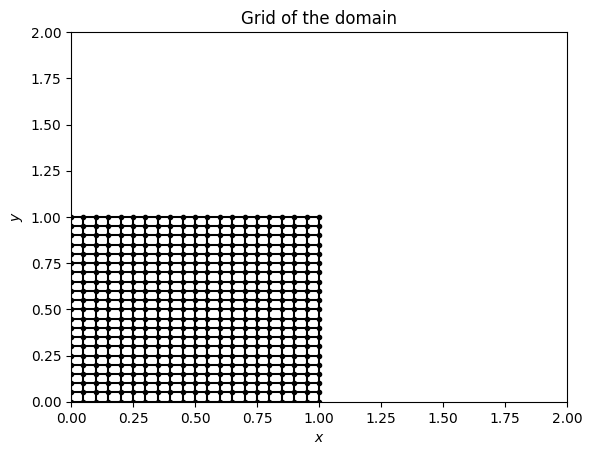

In [47]:
Lx = 2
Ly = 2
dx = 0.05
dy = 0.05
cavity = domain(Lx, Ly, dx, dy)

T = 0.15
dt = 0.005
rho = float(1.0)
nu = float(0.1)
eta = float(nu/rho)
cavity.velocity(T, dt, eta, rho)


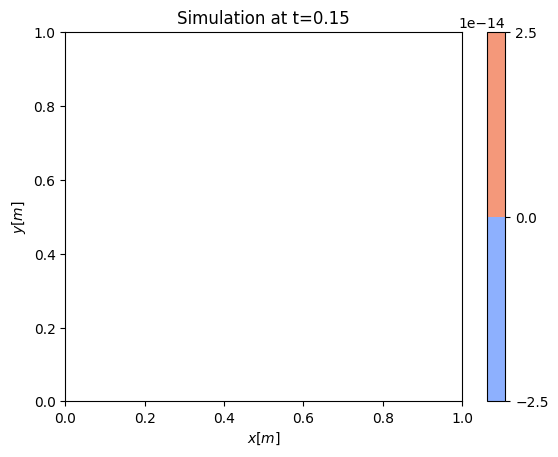

In [48]:
cavity.plotter()

In [41]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
print(dx, dy)

0.05 0.05
